In [1]:
import math
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy.random as rng
from scipy.optimize import minimize_scalar

##  Illustration de la méthode de simulation d’un processus de Poisson homogène ou inhomogène par la méthode de thinning
---

## Objectif

Ce notebook a pour but d’illustrer la simulation de **processus de Poisson**, qu’ils soient **homogènes** ou **inhomogènes**, à l’aide de la méthode de **thinning** (*échantillonnage par acceptation/rejet*).

Les processus de Poisson permettent de modéliser des événements aléatoires dans le temps (ou l’espace) comme :
- des appels téléphoniques,
- des crises médicales,
- des phénomènes naturels comme l’activité volcanique.

Dans un **processus de Poisson homogène**, les événements surviennent à une fréquence constante `λ`.  
Dans un **processus inhomogène**, cette intensité `λ(t)` varie au cours du temps.

La méthode du **thinning**, introduite par Lewis & Shedler (1979), permet de simuler un processus inhomogène à partir d’un processus homogène de taux maximal.

---

### Plan du notebook

1. **Defintions mathématiques**
    - Processus de Poisson homogène
    - Processus de Poisson inhomogène
    - Méthode du thinning
   


2. **Implémentation des outils de simulation**
   - Génération de processus homogènes (`p_ponctuel`, `p_comptage`)
   - Fonction de maximisation
   - Fonction `poisson_inhomogene_thinning`
     
3. **Étude de différentes intensités `λ(t)`**
   - Constante
   - Sinusoïdale
   - Exponentielle décroissante
   - Gaussienne
   - Linéaire croissante
   - Graphes avec `λ(t)` + événements acceptés / rejetés

4. **Cas d’étude réaliste**
   - Activité volcanique
   - Activité sur une plateforme de streaming audio 
   - Urgences pédiatriques

5. **Conclusion**
   - Limites de la méthode
   - Ouvertures possibles


## 1. Defintions mathématiques

### Processus de Poisson – Formulation mathématique

####  Processus de Poisson homogène

Un **processus de Poisson homogène** `(N(t))` d’intensité `λ` (constante), défini pour `t ≥ 0`, est construit à partir des temps d’arrivée :

Tₙ = S₁ + S₂ + ... + Sₙ avec T₀ = 0,


où les `Sᵢ` sont des variables aléatoires indépendantes et identiquement distribuées (**i.i.d.**) suivant une loi **exponentielle de paramètre `λ`**.

Le processus s’écrit :


                                            N(t) = sup { n | Tₙ ≤ t }
                                        

Il compte le **nombre d’événements survenus jusqu’au temps `t`**.

---

#### Processus de Poisson inhomogène

Un **processus de Poisson inhomogène** est défini de manière analogue, sauf que l’intensité `λ` devient une **fonction `λ(t)`**, mesurable, positive et bornée.  
Cette fonction permet de modéliser une **intensité qui varie dans le temps**.

---

### Méthode du thinning (éclaircissement)

La méthode du *thinning* permet de simuler un processus de Poisson **inhomogène** à partir d’un processus **homogène** d’intensité constante.

#### Étapes :

1. Générer un processus homogène d’intensité `λmax`, un **majorant** de la fonction `λ(t)` (on choisit `λmax` le plus petit possible, avec `λ(t) ≤ λmax` pour tout `t`).

2. Pour chaque événement simulé à l’instant `t`, générer une variable aléatoire `U ~ U([0,1])` (loi uniforme).

3. Si `U ≤ λ(t)/λmax`, **accepter l’événement** ; sinon, le **rejeter**.

---

Les événements acceptés forment alors un **processus de Poisson inhomogène** d’intensité `λ(t)`.

Cette méthode est simple, intuitive, et très utilisée pour simuler des processus temporels réels à intensité variable.


## 2. Implémentation des outils de simulation

In [6]:
def p_ponctuel(lambd, seuil):
    debut = 0
    nb = []

    while debut < seuil:
        saut = rng.exponential(1 / lambd)
        debut += saut
        if debut < seuil:
            nb.append(debut)

    return np.array(nb)


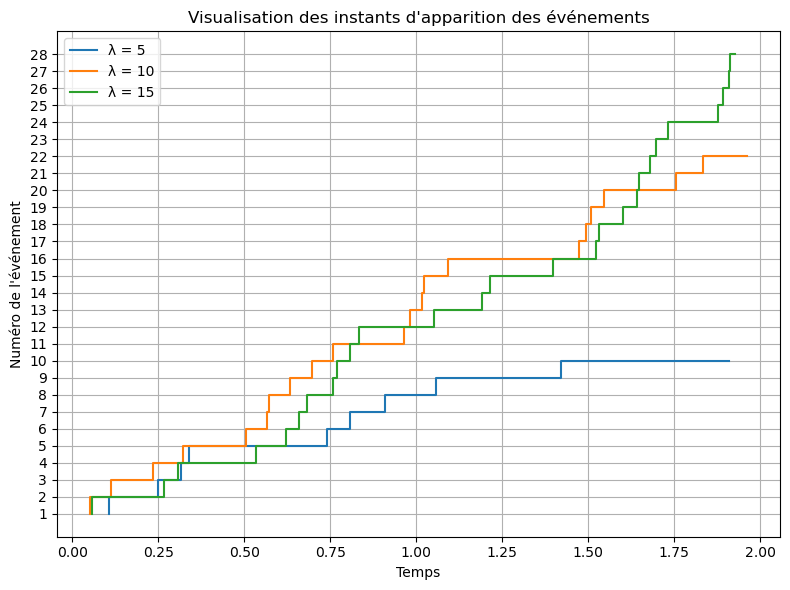

In [7]:
lambd = [5,10,15]
seuil = 2
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(3):
    
    issue = p_ponctuel(lambd[i], seuil)
    ax.step(issue, np.arange(1, len(issue)+1), label=f"λ = {lambd[i]}")
ax.set_title("Visualisation des instants d'apparition des événements")
ax.set_xlabel("Temps")
ax.set_ylabel("Numéro de l'événement")
ax.set_yticks(np.arange(1, len(issue)+1))
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


#### Visualisation des événements générés par `p_ponctuel`

Le graphique ci-dessus montre l’ordre d’apparition des événements d’un processus de Poisson homogène simulé avec `λ = 5` ,  `λ = 10` et `λ = 15`sur l’intervalle `[0, 2]`.

Chaque marche correspond à un événement.  
Les temps d’attente suivant une loi exponentielle, on a donc un escalier irregulier, montrant bien la nature aléatoire du processus.

On remarque bien que la courbe monte plus vite pour `λ = 15`(événement n°18 à t = 1), que  `λ = 10` (événement n°9 à t = 1) et encore plus vite que pour    `λ = 5` (événement n°6 à t = 1) 


In [9]:
def p_comptage(lambd, seuil):
    ponctuel = p_ponctuel(lambd, seuil)
    x = np.linspace(0, seuil, 1000)
    comptage = np.array([np.sum(ponctuel <= xi) for xi in x])
    return ponctuel, x, comptage 



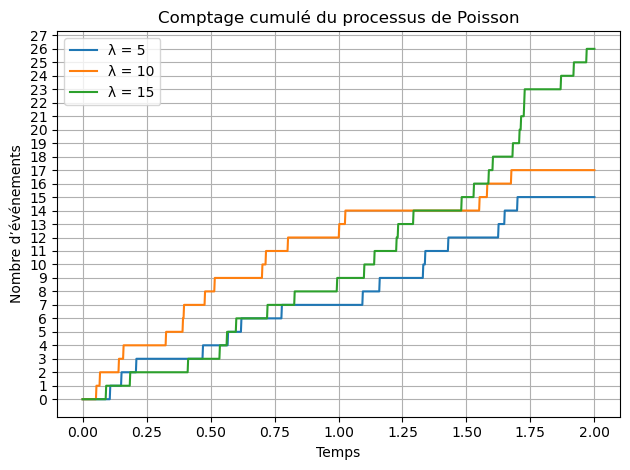

In [10]:

fig, ax = plt.subplots()
for i in range(3):
    ponctuel, x, comptage = p_comptage(lambd[i], seuil)
    ax.plot(x, comptage, label=f"λ = {lambd[i]}")
ax.set(xlabel="Temps", ylabel="Nombre d’événements", title="Comptage cumulé du processus de Poisson")
ax.set_yticks(range(0, int(max(comptage)) + 2))
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()



#### Comptage cumulé d’un processus de Poisson homogène

Le graphique ci-dessus montre l'évolution du **nombre total d’événements** dans un **processus de Poisson homogène** simulé pou  plusieurs intensités constante  `λ = 5` ,  `λ = 10` et `λ = 15`, sur une durée `T = 2`.

La courbe pour chaque `λ` est une **fonction en escalier croissante** :
- Chaque saut correspond à un **événement qui se produit**.
- Les paliers horizontaux indiquent les **périodes sans événement**.
- La montée irrégulière reflète le **caractère aléatoire** du processus.



Ce graphique (`p_comptage`) ne montre pas **quand** chaque événement se produit, mais **combien** ont eu lieu jusqu’à chaque instant.

Contrairement au graphe basé sur `p_ponctuel`, qui affiche les **instants d’apparition individuels**, celui-ci permet de **suivre l'accumulation globale** des événements dans le temps, ce qui est utile pour analyser le rythme d’apparition.


C’est donc une représentation plus synthétique du processus, adaptée aux comparaisons entre plusieurs intensités `λ`.
Cependant, on remarque bien une cohérence entre les deux graphiques car on remarque exactement la même chose sur les deux , c'est à dire que la courbe monte plus vite pour `λ = 15`. Ce qui est tout a fait cohérent.


###  Simulation d’un processus de Poisson homogène : `p_ponctuel` et `p_comptage`

Comme on l'a vu dans la partie 1, un **processus de Poisson homogène** modélise des événements qui apparaissent aléatoirement dans le temps, mais à une fréquence constante `λ` (appelée **intensité**).

Pour le simuler, on a donc créé deux fonctions complémentaires :

`p_ponctuel(lambd, seuil)` : génère les temps d’apparition des événements. Ces temps sont obtenus en additionnant des intervalles aléatoires tirés d’une loi exponentielle de paramètre `λ`, ce qui reflète la nature aléatoire et sans mémoire du processus.

`p_comptage(lambd, seuil)`: prend ces événements et calcule, pour chaque point d’une grille de temps régulière, le nombre total d’événements survenus jusqu’à ce moment. Cela permet de représenter le comptage cumulé du processus sous forme d’une courbe en escalier croissante.

Ensemble, ces deux fonctions permettent de générer un **processus de Poisson homogène** dans un intervalle donné [0, seuil] ; et de visualiser comment le processus évolue dans le temps, ce qui est essentiel pour l’analyse statistique ou la comparaison avec un processus inhomogène.

Ces deux fonctions vont nous servir de base pour pouvoir modéliser un **processus de Poisson inhomogène avec la méthode du thinning.**

In [13]:
def maximum(f, borne_min=0, borne_max=100):
    def f_sûre(x):
        try:
            val = f(x)
            if not np.isfinite(val):
                return 1e10
            return -val
        except:
            return 1e10

    res = minimize_scalar(f_sûre, bounds=(borne_min, borne_max), method='bounded')
    return -res.fun



Cette fonction nous permer de trouver le **maximum** d'une fonction sur un intervalle (qu'on initialise par defaut à [0,100]), cela nous permets de faciliter notre utilisation
de la **methode du thinning**

In [15]:
def poisson_inhomogene_thinning(f, seuil):
    lmax = maximum(f)
    événements, _, _ = p_comptage(lmax, seuil)
    fx = f(événements)
    unif = rng.uniform(size=len(événements))
    acceptation = unif < fx / lmax
    accepted = événements[acceptation]
    rejected = événements[~acceptation]
    return accepted, rejected

Le code de notre fontion `poisson_inhomogene_thinning` nous donne accès aux **points acceptés et rejetés** par la methode du thinning.

## 3. Étude de différentes intensités `λ(t)`

Dans cette partie , nous allons tester nos fonctions et donc **la methode du thinning** pour differentes fonctions `λ`

In [19]:
lambda_const = lambda t: 5 * np.ones_like(t)
lambda_sin = lambda t: 5 + 3 * np.sin(2 * np.pi * t / 8)
lambda_exp = lambda t: 10 * np.exp(-0.5 * np.clip(t, a_min=0, a_max=None))
lambda_gauss = lambda t: 10 * np.exp(-((t - 5)**2) / (2 * 1.5**2))
lambda_lin = lambda t: 2 + 0.5 * t


In [20]:
def afficher_thinning(f, seuil, nom=""):

    accepted, rejected = poisson_inhomogene_thinning(f, seuil)

    ts = np.linspace(0, seuil, 1000)
    lambdas = f(ts)
    
    plt.figure(figsize=(12, 5))
    plt.plot(ts, lambdas, label="λ(t) - Intensité", color='darkred', linewidth=2)
    plt.vlines(accepted,ymin =0.0 , ymax =1 ,color='blue', linestyle='-', alpha=0.8, linewidth=1, label="points acceptés")
    plt.vlines(rejected,ymin =0.0 , ymax =1,color='green', linestyle='--', alpha=0.8, linewidth=1, label ="point rejetés")
    plt.axvline(x=seuil, color='black', linestyle='--', alpha=0.5, label='Seuil')

    plt.title(f"Thinning – {nom}")
    plt.xlabel("Temps")
    plt.ylabel("Intensité / Événements")
    plt.ylim(0, np.max(lambdas) + 2)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()




### Visualisation de la méthode du thinning

La fonction `afficher_thinning` nous permet de visualiser le résultat de la méthode du *thinning* (`poisson_inhomogene_thinning`) qu'on a codé plus haut. 

---
Cette fonction va nous faciliter la visualisation de notre méthode. Elle nous permet d'afficher les éléments suivants :

- **Une courbe rouge** qui représente la fonction d’intensité `λ(t)`.
- **Des traits verticaux bleus** qui correspondent aux événements **acceptés**, c’est-à-dire ceux qui ont été conservés après la méthode du thinning. Ils constituent le processus de Poisson inhomogène simulé.
- **Des traits verticaux verts en pointillés** qui représentent les événements **rejetés** par la méthode du *thinning* : ils ont été générés par le processus homogène de taux  `𝜆max`, mais éliminés avec une certaine probabilité.( `λ(t)/λmax` )
- **Une ligne verticale noire en pointillé** qui marque le **seuil de simulation** (la limite temporelle qu'on a choisie).

---

Le graphique issue de cette fonction nous permettra de comprendre comment la densité des événements acceptés varie selon la forme de `𝜆` :
- Si `𝜆(t)` est élevée, on observe plus d'événements bleus (acceptés).
- Si `𝜆(t)` est faible, les événements sont plus espacés et les rejets sont plus nombreux.



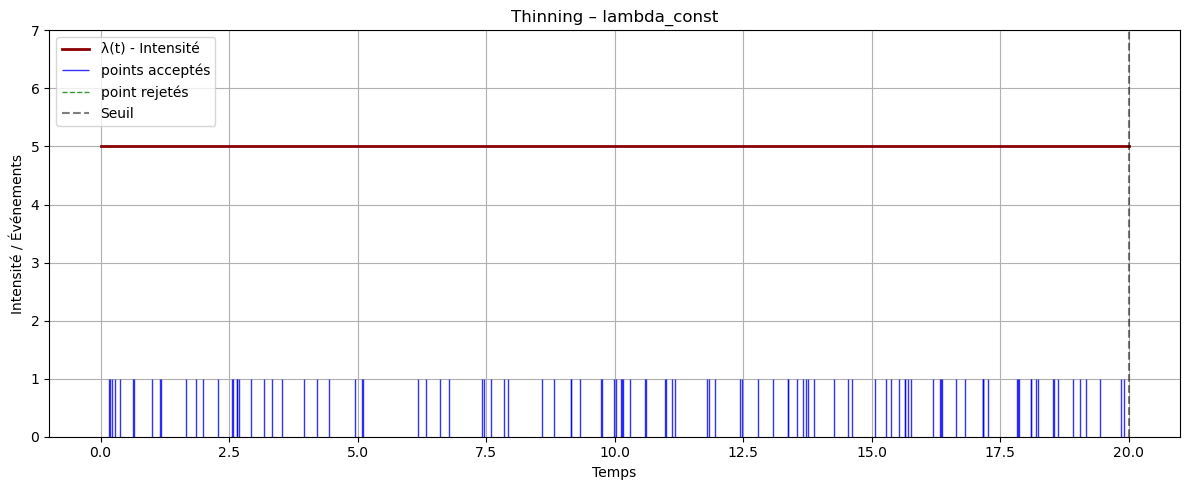

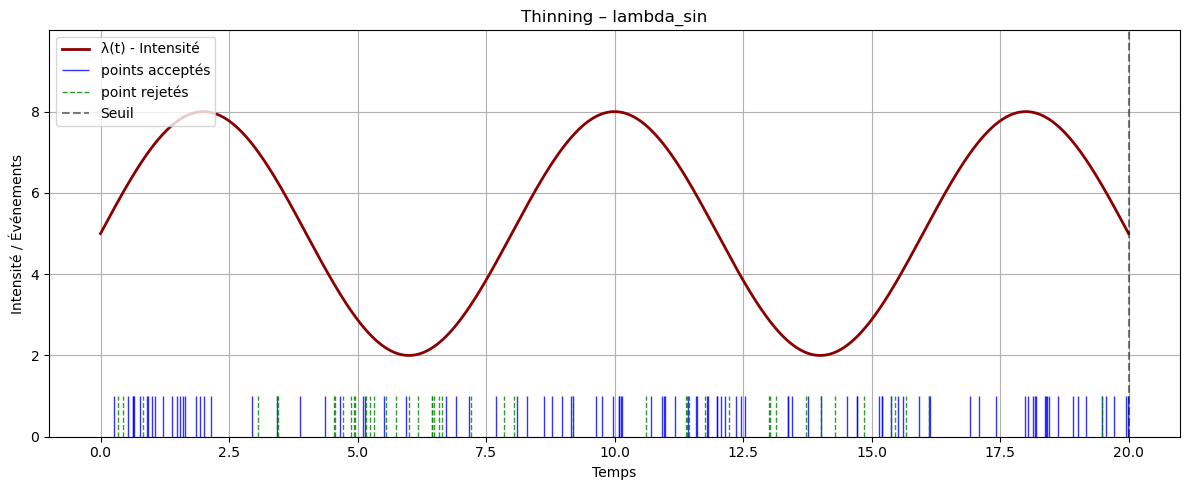

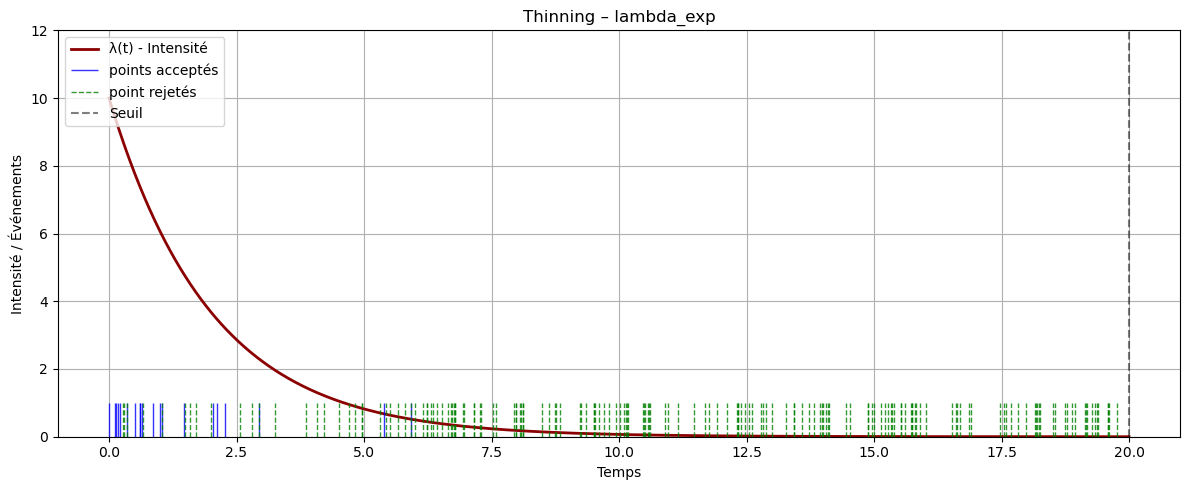

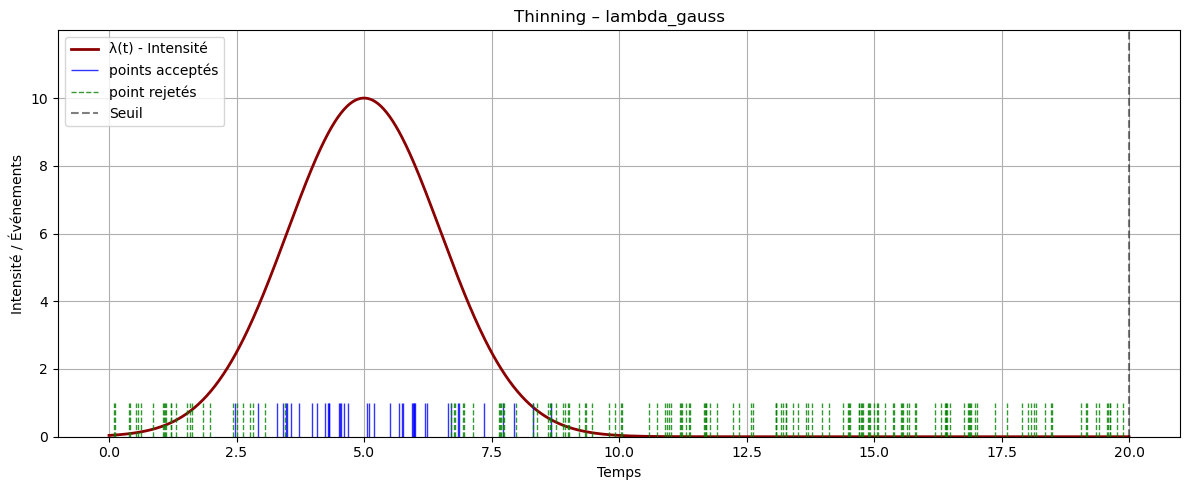

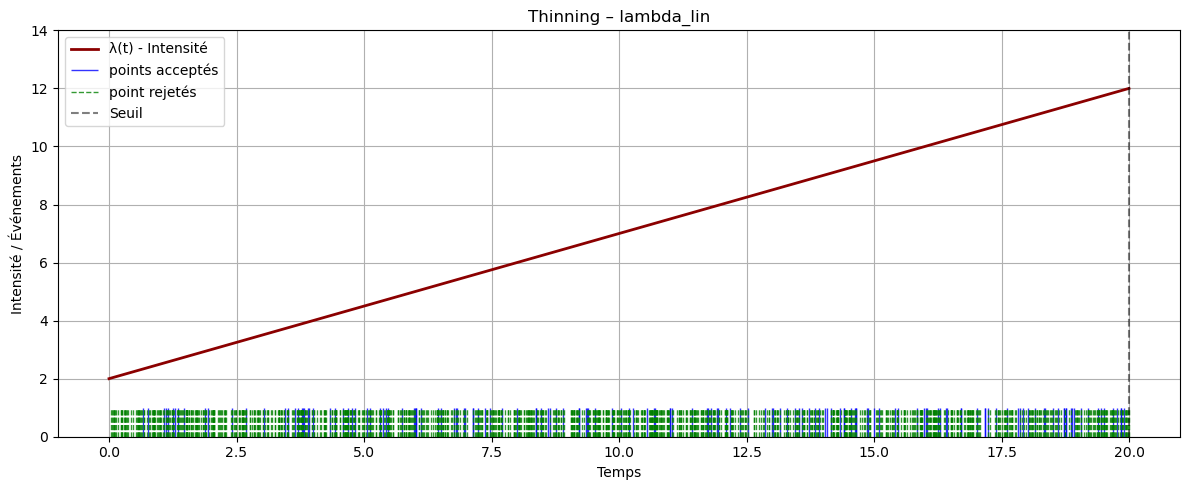

In [22]:
seuil2 = 20 #on augmente le seuil pour avoir plus d'événements et mieux visualiser
lambdas = [("lambda_const", lambda_const),
    ("lambda_sin", lambda_sin),
    ("lambda_exp", lambda_exp),
    ("lambda_gauss", lambda_gauss),
    ("lambda_lin", lambda_lin)]
for nom , lambd in lambdas:
    afficher_thinning(lambd ,seuil2 , nom)



###### `lambda_const` : (𝜆(t) = 5)
- Intensité constante.
- Aucun événement rejeté (puisque 𝜆(t) = 𝜆(max) = 5 ).
- Les événements sont **uniformément répartis dans le temps**, ce qui donne un processus homogène.

---

##### `lambda_sin` : (𝜆(t) =  5 + 3sin(2πt / 8))
- Intensité **périodique** oscillant entre 2 et 8.
- Les événements sont plus denses dans les zones où 𝜆 est haute.
- Beaucoup de **rejets** dans les creux de la sinusoïde (où l’intensité est faible).

---

##### `lambda_exp` : ( 𝜆(t)= 10 exp(-0.5t))
- Intensité **décroissante** dans le temps.
- Forte densité d’événements au début, qui diminue progressivement.
- Cela illustre bien une **accélération suivie d’un ralentissement** du processus.

---

##### `lambda_gauss` : (𝜆(t) = 10exp(-((t - 5)²)/(2 * 1.5²)) )
- Forme en **cloche centrée** vers t = 5
- Les événements sont concentrés **autour du pic**, comme prévu.
- Début et fin de l’intervalle sont très peu actifs.

---

##### `lambda_lin` : ( 𝜆(t) = 2 + 0.5t )
- Intensité **linéairement croissante** de 2 à 4.5.
- Peu d’événements au début, et **densité croissante** dans le temps.
- Les rejets sont plus fréquents au début, car la probabilité d'acceptation est plus faible.

---

##### Conclusion
Ces visualisations montrent clairement que la méthode du *thinning* permet de produire un processus de Poisson inhomogène **fidèle à la fonction d’intensité 𝜆(t)** imposée.  
Les événements acceptés respectent la variation locale de 𝜆(t), tandis que les événements rejetés assurent une cohérence statistique avec le processus homogène initial.



On peut utiliser notre code pour modeliser des evenements inspiré de la vie reelle comme une activité volcanique , l'activité su une plateforme de streaming ou  encore une urgence medicale!

## 4. Cas d’étude réaliste

### Modele d'intensité pour une activité volcanique

Pour modéliser l’activité d’un volcan, on utilise une **somme de fonctions gaussiennes**, chaque gaussienne représentant une **éruption localisée dans le temps**.  

À cela, on ajoute un **fond résiduel**, qui reflète l’activité volcanique de base.  
En effet, en dehors des pics d’éruption, un volcan peut toujours produire :
- des **petites secousses**,
- des **retombées de cendres**,
- ou d’autres phénomènes mineurs.

Ce fond résiduel est généralement **faible** et **continu**, mais il est visuellement **écrasé lors des pics d’éruption**, car ceux-ci dominent largement l’intensité du processus à ces moments-là.


Nous avons décidé de travailler sur l’activité du volcan **Etna** sur une période de **12 mois**, correspondant à l’année **2025**.  
Durant cette année, plusieurs éruptions ont été recensées. Nous allons particulièrement nous intéresser aux suivantes :

- **Février 2025** intensité : élevée
- **Avril 2025** intensité : modérée
- **Juillet 2025** intensité : faible/modérée 

Ces dates serviront de repères pour modéliser l’intensité de l’activité volcanique au cours de l’année à l’aide de pics gaussiens.
On va donc avoir un pic a t= 2 , t = 4 et t=7. Ensuite on choisi le facteur A, qui representera l'intensité de l'éruption , et pour finir σ qui representera la durée.

Nos fonctions gaussiennes seront de la forme: 

                                                    f(x) = A*exp(-(x-t)²/(2σ²))

On peut remarquer qu’un facteur 2 a été ajouté à la fonction d’intensité.  
Cela permet d’**augmenter le nombre d’événements simulés** sans modifier le paramètre `seuil`, qui représente la **durée totale de la simulation**
, ici 12 mois.  
Autrement dit, on **augmente la densité des événements** sur le même intervalle de temps.


In [63]:
def lambda_etna(t):
    t = np.array(t)
    eruption1 = 10 * np.exp(-((t - 2)**2) / (2 * 0.5**2))
    eruption2 = 5 * np.exp(-((t - 4)**2) / (2 * 0.7**2))
    eruption3 = 3 * np.exp(-((t - 7)**2) / (2 * 0.9**2))
    # Activité résiduelle lente
    fond = 1 + 1.5 * np.exp(-0.4 * t)
    return 2*(eruption1 + eruption2 + eruption3) +fond

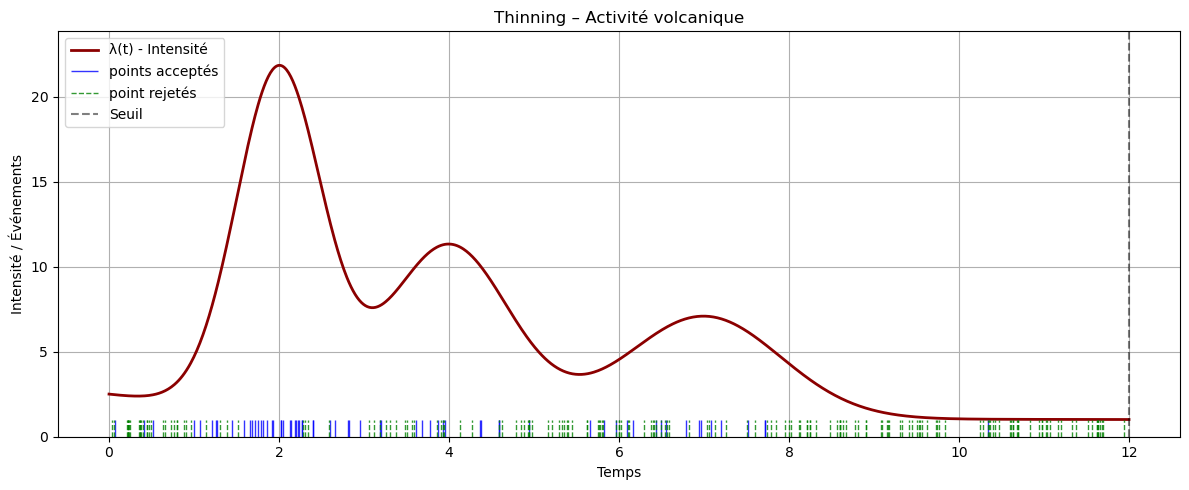

In [31]:
afficher_thinning(lambda_etna, seuil=12, nom="Activité volcanique")

- La méthode du **thinning** fonctionne bien : plus 𝜆(t) est élevée, plus les événements bleus sont denses.
- Les zones calmes (fin d’année) montrent peu d’événements acceptés mais encore quelques rejets → l’activité de fond est modélisée.
---
Ce modèle simule donc l'activité volcanique de l'Etna en 2025, avec des pics soudains et une base continue.


 ### Modéle d'intensite - Activité sur une plateforme de streaming audio 


Dans ce modèle, nous cherchons à modéliser le nombre d’utilisateurs connectés à une plateforme  au cours d’une journée.


Voici les hypothèses retenues sur l’affluence en fonction des moments de la journée :

- Faible activité la nuit (0h–6h),
- Montée progressive le matin (7h–9h),
- Baisse légère en milieu de journée,
- Forte activité en soirée (18h–22h),
- Retombée progressive après 23h.

Ce comportement cyclique et naturel est bien représenté par une fonction **sinusoïdale**. Parce qu’un sinus varie régulièrement entre un minimum et un maximum.

La forme générale du sinus est :
                                         
                                                    λ(t)=A+B⋅sin(2π/T*(t−x))
Avec 

A : Niveau moyen (valeur au centre de l’oscillation)

B : Amplitude (variation au-dessus et en dessous du niveau moyen)

T : Période (en combien d’unités de temps on fait un cycle complet)

x : Décalage horizontal (pour placer le pic où l'on veux)

---


##### Choix des paramètres pour le modèle sinusoïdal

Dans notre cas, on souhaite modéliser une activité **cyclique sur une journée complète (24h)**.  
Voici les paramètres choisis pour construire la fonction d’intensité sinusoïdale \( \lambda(t) \) :

- **Période** ( T = 24 ) : un cycle complet en 24 heures.
- **Valeur moyenne** ( A = 4 ) : niveau d’activité moyen au cours de la journée.
- **Amplitude** ( B = 3 ) : variation entre un minimum de ( A - B = 1 ) et un maximum de ( A + B = 7 ).
- **Décalage** ( x = 6 ) : pour faire en sorte que le **pic d’activité se produise à ( t = 18 )**.




In [36]:
def lambda_streaming(t):
    t = np.array(t)
    return 4 + 3 * np.sin(2 * np.pi * (t - 6) / 24)

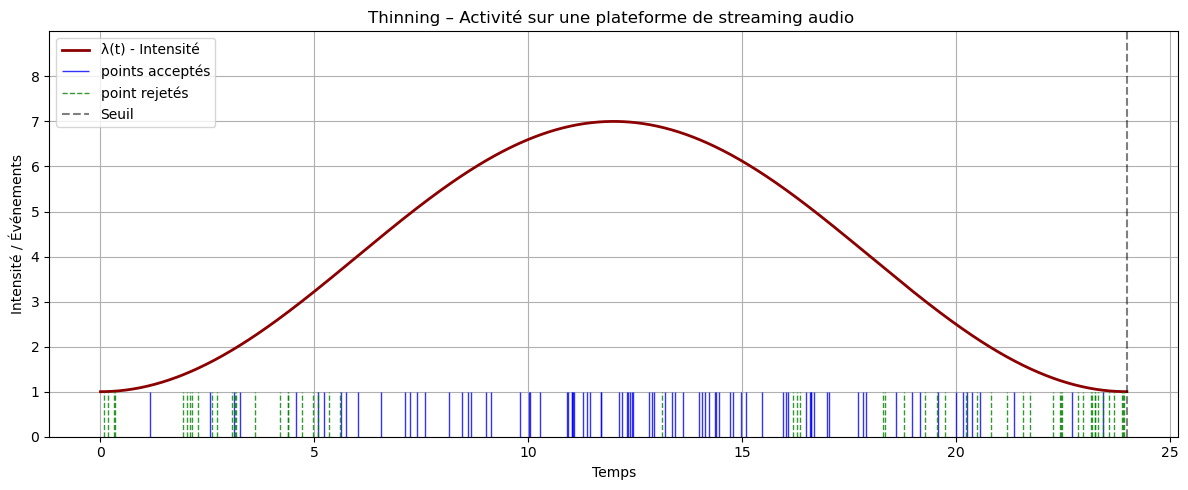

In [37]:
afficher_thinning(lambda_streaming, seuil=24, nom="Activité sur une plateforme de streaming audio ")

- Les événements bleus sont **concentrés autour du pic** d’intensité, ce qui est logique : plus la fonction d'intensité est élevée, plus la probabilité d'accepter un événement est forte.
- Inversement, peu d’événements sont acceptés la nuit, ce qui reflète bien une **baisse d’activité réelle**.
- On observe également que la densité des **points rejetés** augmente là où l’intensité est basse, ce qui montre que le processus homogène génère trop d'événements dans ces zones, mais que le thinning filtre correctement.

---

Ce modèle illustre donc parfaitement un **phénomène d’usage cyclique**, comme l’activité des utilisateurs sur une application, en lien avec leurs habitudes journalières.

### Modèle d’intensité - Urgences pédiatriques


Dans ce modèle, nous cherchons à représenter le **nombre d’arrivées de patients aux urgences pédiatriques** au cours d’une journée typique (0h–24h), basé sur le fonctionnement observé dans des hôpitaux comme l’hôpital Armand-Trousseau (Paris), l’un des plus grands services d’urgences pédiatriques d’Île-de-France.

Voici les hypothèses retenues sur l’affluence au fil des heures :

- Faible activité durant la nuit (0h–6h),
- Montée progressive des arrivées dès 6h du matin,
- Activité soutenue entre 12h et 17h,
- Pic d’activité attendu en début de soirée (vers 18h–20h),
- Diminution progressive après 22h.

---

Ce comportement **non cyclique mais asymétrique** est modélisé par une combinaison :
- d'une **fonction logistique (tanh)** pour la montée du matin,
- d'une **gaussienne** pour le pic de fin d’après-midi,
- et d'un **fond constant** pour simuler les cas nocturnes.

Nous utilisons la fonction tanh pour représenter une **montée progressive et réaliste** de l’intensité au fil du temps, notamment le matin.

-Le coefficient 0.6 contrôle la vitesse de montée (plus il est grand, plus la montée est rapide).

-Le décalage (t - 6) permet de commencer la montée à t = 6 (soit 6h du matin).

-Le facteur multiplicatif 2 ajuste l’amplitude de l’effet du matin.


Afin d’augmenter le nombre d’événements simulés dans la même plage temporelle, nous avons multiplié les composantes de la fonction d’intensité par un facteur (×2), comme pour le modèle sur le volcan de l'Etna.


In [42]:

def lambda_trousseau(t):
    t = np.array(t)
    matin = 2 * np.tanh(0.6 * (t - 6)) 
    soir = 2.5 * np.exp(-0.1 * (t - 18)**2)  
    fond = 1  
    return fond +2* matin + 2*soir


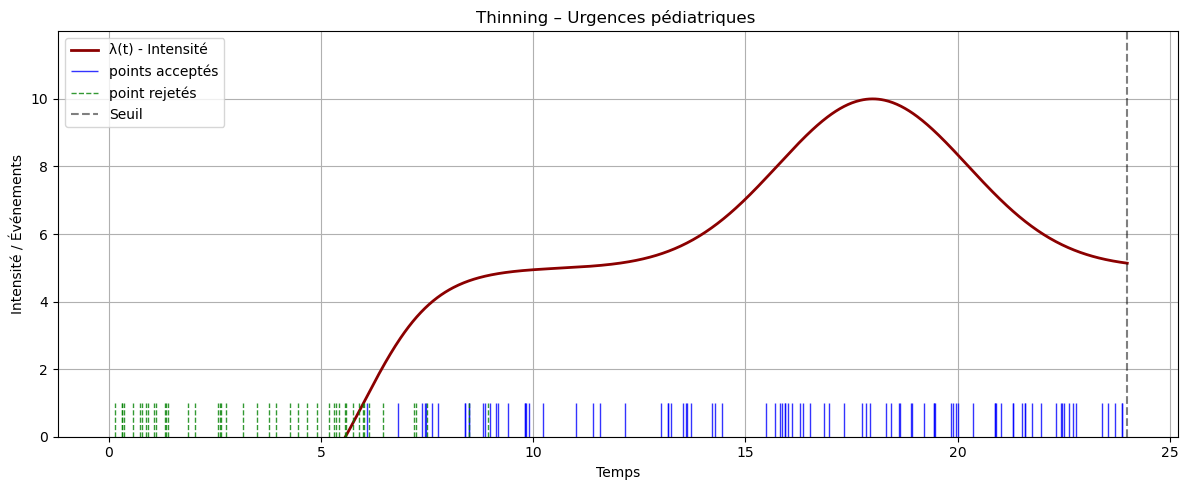

In [43]:
afficher_thinning(lambda_trousseau, seuil=24, nom="Urgences pédiatriques ")

- Les événements acceptés se concentrent autour du **pic du soir**, ce qui valide que le modèle suit bien la dynamique voulue.
- Très peu d'événements sont acceptés pendant la nuit, ce qui reflète bien le **calme nocturne aux urgences**.
- Le **fond constant** garantit tout de même quelques arrivées isolées même lorsque \( \lambda(t) \) est bas.

---

Ce modèle montre la souplesse de la méthode de simulation par *thinning*, et son efficacité à reproduire une intensité **réaliste, asymétrique et adaptée à un phénomène non périodique**.


## 5. Conclusion

Pour conclure un **processus de poisson homogène** est plus simple à modéliser mais moins réaliste qu'un **processus inhomogène** qui lui varie dans le temps (finance, trafic)

La méthode du thinning est une méthode efficace pour générer un processus inhomogène car elle est :

-simple à implémenter grâce aux générateurs standards

-générale car fonctionne avec une fonction d'intensité tant qu'elle est positive mesurable bornée

-sans grand coût numérique (pas besoin d'intégrer de fonction ou d'inverser la fonction d'intensité)

Cependant elle peut avoir des inconvénients :

-si `λmax` est un trop grand majorant de la fonction d'intensité, il faudra générer beaucoup d'uniformes pour que les évènements soient acceptés ce qui fait perdre du temps

-`λmax`  peut-être difficile à calculer si la fonction d'intensité possède beaucoup de maximums locaux

-La méthode ne fonctionne pas si la fonction d'intensité n'est pas bornée

Une autre méthode nommée la méthode du temps transformé qui consiste à inverser la fonction d'intensité est aussi utilisée pour générer des processus de poisson inhomogènes, ainsi si la méthode du thinning est non possible ou moins efficace (fonction d'intensité non bornée ou fonction d'intensité facile à intégrer et à inverser) alors la méthode du temps transformé sera plus utile.